# Backgrounds in opticam_new

`opticam_new` uses `photutils` to handle two-dimensional image backgrounds. In this notebook, I will demonstrate how to define backgrounds for use with `opticam_new`, as well as explain `opticam_new`'s default behaviour when no background is specified.

## Test Image

First thing's first, let's open an image so we can compute its background. For this example, I'll use one of the images from the [Basic Usage tutorial](basic_usage.ipynb):

In [1]:
from opticam_new.generate import create_synthetic_observations

create_synthetic_observations(out_dir='data', overwrite=True)  # generate some synthetic observations

Creating synthetic observations: 100%|██████████| 100/100 [00:11<00:00,  8.56it/s]


In [2]:
from astropy.io import fits
import numpy as np
import os

files = os.listdir('data')

with fits.open(f"data/{files[0]}") as hdul:
    print(repr(hdul[0].header))
    image = np.array(hdul[0].data)

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                  256                                                  
EXTEND  =                    T                                                  
FILTER  = 'i       '                                                            
BINNING = '8x8     '                                                            
GAIN    =                  1.0                                                  
UT      = '2024-01-01 00:00:49'                                                 


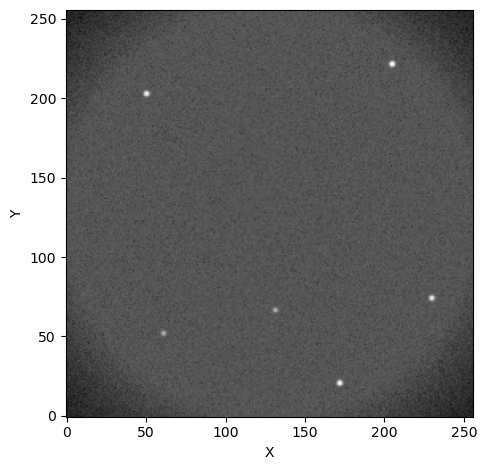

In [3]:
from astropy.visualization import simple_norm
from matplotlib import pyplot as plt

fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(image, norm=simple_norm(image, stretch="sqrt"), origin="lower", cmap="Greys_r")

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

## Default Background

`opticam_new`'s default background estimator is the default `Background2D()` estimator from `photutils` with some added convenience tailored to OPTICAM. . Let's look at the background image produced by the default estimator:

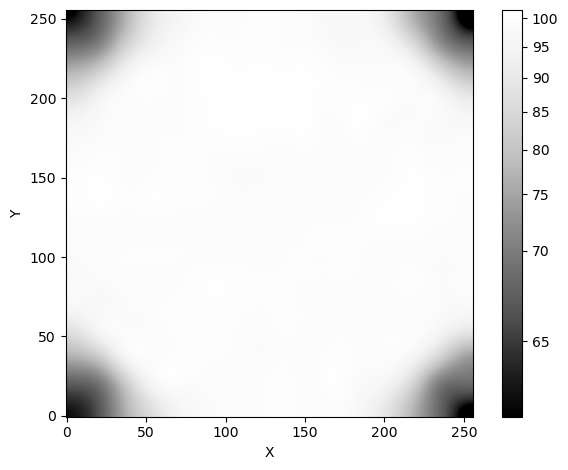

In [4]:
from opticam_new import Background

default_background = Background(box_size=None)  # create a background object using the default box_size

bkg = default_background(image)  # compute the background
bkg_image = bkg.background  # get the background image

fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(bkg_image, norm=simple_norm(bkg_image, stretch="sqrt"), origin="lower", cmap="Greys_r")

fig.colorbar(im)

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

Unsurprisingly, there is a lot of background in the middle of the image, with less in the corners (since we have not applied [flat-field corrections](applying_corrections.ipynb)). We can also look at the background mesh to see if any regions of the image have been excluded by the background estimator:

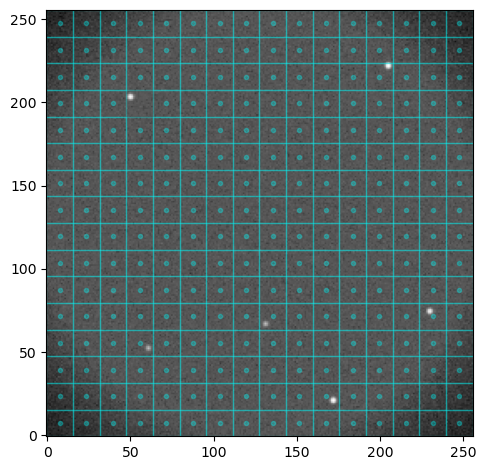

In [5]:
fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(image, norm=simple_norm(image, stretch="sqrt"), origin="lower", cmap="Greys_r")
bkg.plot_meshes(outlines=True, marker='.', color='cyan', alpha=0.3, ax=ax)

plt.show()

The default size of the background "pixels" for `opticam_new.Background` is the width of the image divided by 16. This value is generally good across a range of observing conditions, but it can, of course, be changed on a case-by-case basis. The `photutils` documentation suggests setting the `box_size` (i.e., background "pixel" size) to a value which is small, but larger than the typical source size. For these simulated data, we could probably get away with a smaller `box_size`, but such fine-tunings are left to the user.

Let's subtract the background and compare the histograms of pixel values before and after removing the background from the image:

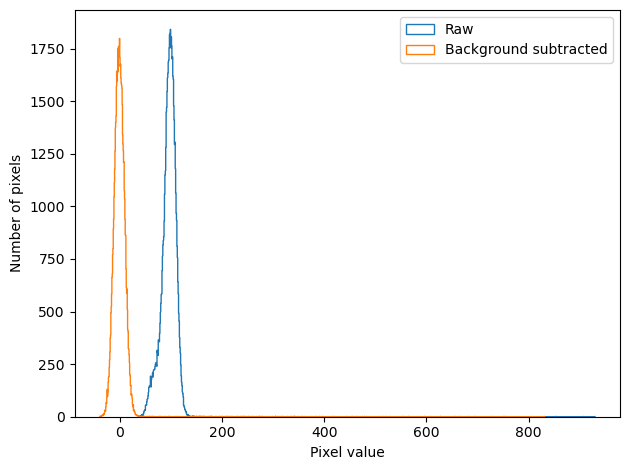

In [6]:
fig, ax = plt.subplots(tight_layout=True)

ax.hist(image.flatten(), bins='auto', histtype="step", label="Raw")
ax.hist((image - bkg_image).flatten(), bins='auto', histtype="step", label="Background subtracted")

ax.set_xlabel("Pixel value")
ax.set_ylabel("Number of pixels")

ax.legend()

plt.show()

We can see that the background has been massively reduced. After subtracting the background, the pixel values (ignoring contributions from sources) appear approximately Gaussian distributed about zero.

Using `opticam_new`'s default background is extremely easy. However, in some cases, we may see better results if we implement a custom background estimator.

## Custom Backgrounds

Let's now define a custom background estimator. Custom background estimators should implement a `__call__()` method that takes an `NDArray` image input and returns a `Background2D` object:

In [7]:
from photutils.background import Background2D

class CustomBackground:
    
    def __init__(self, box_size, bkg_estimator, bkgrms_estimator):
        self.box_size = box_size
        self.bkg_estimator = bkg_estimator
        self.bkgrms_estimator = bkgrms_estimator
    
    def __call__(self, image):
        
        return Background2D(image, self.box_size, bkg_estimator=self.bkg_estimator,
                            bkgrms_estimator=self.bkgrms_estimator)

In this example, I have defined the background object to take three parameters. These parameters are:
- `box_size` : the size of the mesh used to create the background image. Effectively the size of the background "pixels".
- `bkg_estimator` : the algorithm used to estimate the background. `photutils` implements several background estimators, as well as allowing custom estimators to be used.
- `bkgrms_estimator` : the algorithm used to estimate the background RMS. `photutils` implements several background RMS estimators, as well as allowing custom estimators to be used.

When an instance of `CustomBackground` is called, it takes an `image` parameter, which is assumed to be an `NDArray`. Note: custom backgrounds **must** implement a `__call__()` method that takes an `NDArray` image input and return a `photutils.background.Background2D` object.

We can use the `photutils` interface to define custom [background](https://photutils.readthedocs.io/en/stable/api/photutils.background.BackgroundBase.html#photutils.background.BackgroundBase) and [background RMS](https://photutils.readthedocs.io/en/stable/api/photutils.background.BackgroundRMSBase.html#photutils.background.BackgroundRMSBase) estimators

In [8]:
from photutils.background import BackgroundBase, BackgroundRMSBase

class BkgEstimator(BackgroundBase):
    """
    Simple background estimator that calculates the median of the (sigma clipped) data.
    """
    
    def calc_background(self, data, axis=None, masked=False):
        """
        Background estimators in photutils must have a `calc_background()` method.
        """
        
        if self.sigma_clip is not None:
            data = self.sigma_clip(data, axis=axis, masked=masked)
        
        return np.nanmedian(data, axis=axis)


class BkgRMSEstimator(BackgroundRMSBase):
    """
    Simple background RMS estimator that calculates the standard deviation of the (sigma clipped) data.
    """
    
    def calc_background_rms(self, data, axis=None, masked=False):
        """
        Background RMS estimators in photutils must have a `calc_background_rms() method`.
        """
        
        if self.sigma_clip is not None:
            data = self.sigma_clip(data, axis=axis, masked=False)
        
        return np.nanstd(data, axis=axis)

For more information on defining custom background and background RMS estimators, I refer to the excellent `photutils` documentation: https://photutils.readthedocs.io/en/stable/background.html#d-background-and-noise-estimation.

For a like-for-like comparison, I will set the `box_size` of `CustomBackground` to the same as that used by `opticam_new.Background`:

In [9]:
custom_background = CustomBackground(box_size=image.shape[0] // 16, bkg_estimator=BkgEstimator(),
                                     bkgrms_estimator=BkgRMSEstimator())

custom_bkg_image = custom_background(image).background

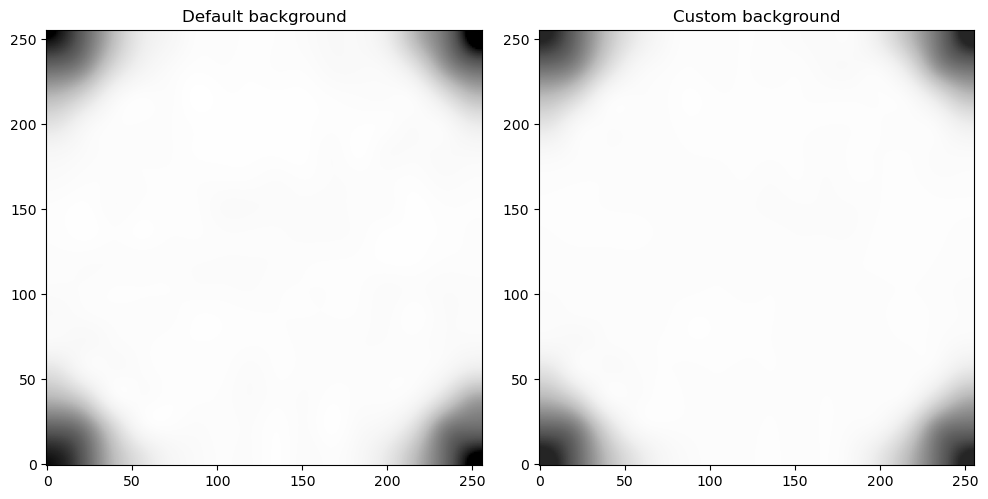

In [10]:
fig, ax = plt.subplots(ncols=2, tight_layout=True, figsize=(10, 5))

im = ax[0].imshow(bkg_image, norm=simple_norm(bkg_image, stretch="sqrt"), origin="lower", cmap="Greys_r")
ax[0].set_title("Default background")

im = ax[1].imshow(custom_bkg_image, norm=simple_norm(bkg_image, stretch="sqrt"), origin="lower", cmap="Greys_r")
ax[1].set_title("Custom background")

plt.show()

As you can see, the two backgrounds are broadly similar (note that they also share the same normalisation). `opticam_new`'s default background estimator uses the SExtractor algorithm to estimate the background, which is given by `2.5 * median - 1.5 * mean`. However, this algorithm will default to the median if `(mean - median) / std > 0.3`. Let's compare the histograms between these two background estimators:

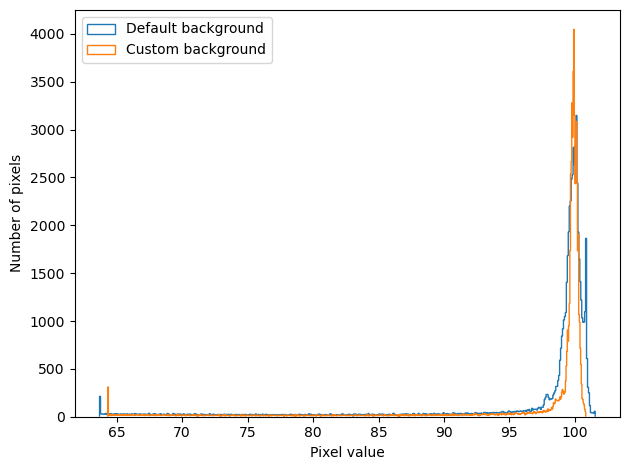

In [11]:
fig, ax = plt.subplots(tight_layout=True)

ax.hist(bkg_image.flatten(), bins='auto', histtype="step", label="Default background")
ax.hist(custom_bkg_image.flatten(), bins='auto', histtype="step", label="Custom background")

ax.set_xlabel("Pixel value")
ax.set_ylabel("Number of pixels")

ax.legend()

plt.show()

As we can see, there are some differences between the two estimators, since the SExtractor algorithm is not always the median value.

That concludes the backgrounds tutorial for `opticam_new`! Much of the heavy lifting here is handled by `photutils`, so I'd highly recommend checking out their documentation for more information on the different background estimators available.